<a href="https://colab.research.google.com/github/Lalasa1234/WaterBody_SemanticSegmentation/blob/main/PyTorchModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from torchvision.transforms import v2
import glob
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import numpy as np
from numpy import asarray

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

SIZE = 256
SEED = 42
BATCH = 32
EPOCHS = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount =True)

Mounted at /content/drive


In [3]:
real_data = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Images/' + '*.jpg'))
masked_data = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/' + '*.jpg'))

In [4]:
# Extracting the first 500 images for experimentation purpose
real_data = real_data[:500]
masked_data = masked_data[:500]
print (len(real_data),len(masked_data))
print (real_data[100:102])
print (masked_data[100:102])

500 500
['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Images/water_body_1118.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Images/water_body_1119.jpg']
['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1118.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1119.jpg']


In [12]:
print ('Real Data - ', Image.open(real_data[2]).mode)
print (asarray(Image.open(real_data[2])).shape, np.transpose(Image.open(real_data[2]),(2,0,1)).shape)
# Masked data looks grayscaled. hence this needs to be changed
test_mask = Image.open(masked_data[2])
print ('Masked Data - ', test_mask.getbands(), asarray(test_mask.convert('L')).shape, np.expand_dims(asarray(test_mask.convert('L')), 0).shape)
print ('Min and max of real data is ',asarray(Image.open(real_data[2])).min(),asarray(Image.open(real_data[2])).max())
print ('Min and max is mask data is ',asarray(test_mask).min(),asarray(test_mask).max())

Real Data -  RGB
(565, 568, 3) (3, 565, 568)
Masked Data -  ('R', 'G', 'B') (565, 568) (1, 565, 568)
Min and max of real data is  0 196
Min and max is mask data is  0 255


### Display real and masked of some images side by side

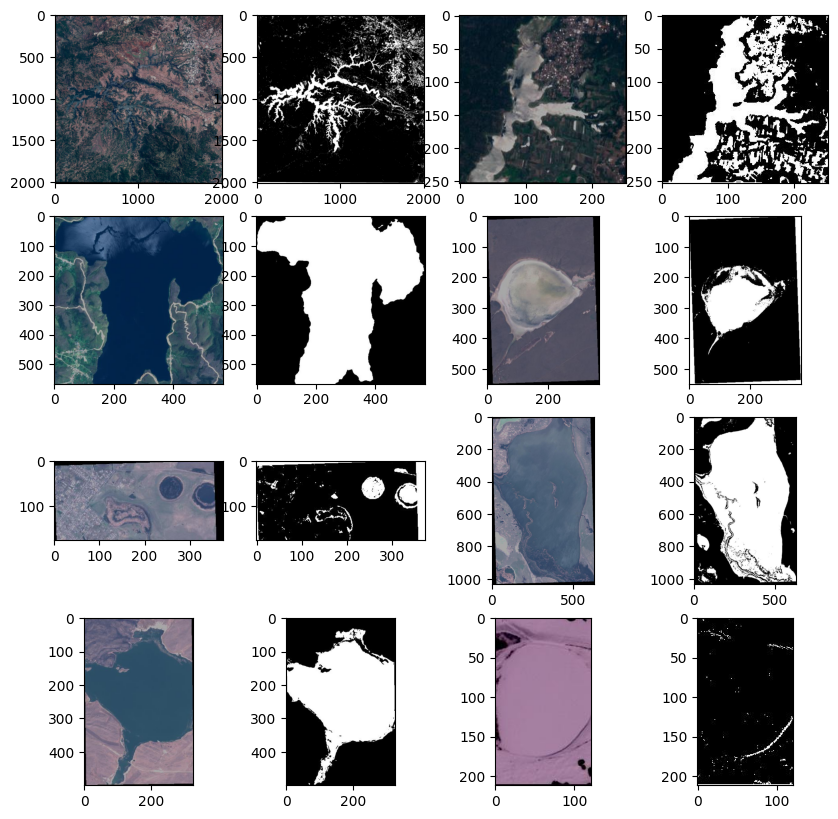

In [5]:
f, ax = plt.subplots(4,4, figsize=(10,10))
ax[0,0].imshow(read_image(real_data[0]).permute(1,2,0))
ax[0,1].imshow(read_image(masked_data[0]).permute(1,2,0))

ax[0,2].imshow(read_image(real_data[1]).permute(1,2,0))
ax[0,3].imshow(read_image(masked_data[1]).permute(1,2,0))

ax[1,0].imshow(read_image(real_data[2]).permute(1,2,0))
ax[1,1].imshow(read_image(masked_data[2]).permute(1,2,0))

ax[1,2].imshow(read_image(real_data[3]).permute(1,2,0))
ax[1,3].imshow(read_image(masked_data[3]).permute(1,2,0))

ax[2,0].imshow(read_image(real_data[4]).permute(1,2,0))
ax[2,1].imshow(read_image(masked_data[4]).permute(1,2,0))

ax[2,2].imshow(read_image(real_data[5]).permute(1,2,0))
ax[2,3].imshow(read_image(masked_data[5]).permute(1,2,0))

ax[3,0].imshow(read_image(real_data[6]).permute(1,2,0))
ax[3,1].imshow(read_image(masked_data[6]).permute(1,2,0))

ax[3,2].imshow(read_image(real_data[7]).permute(1,2,0))
ax[3,3].imshow(read_image(masked_data[7]).permute(1,2,0))

### How to decide which kind of transformations to apply?
- 8th image set has dimension as low as 120, hence **re-sizing** all images to 128 seems reasonable
- 4th and 5th images are slightly **rotated** towards right upto 30 deg, with **black padding in images and no padding in mask**. Similar transformation can be implemented.
- **Horizontal** and **vertical flip** makes sense as the image could have been captured by the satellite in any angle
- 5th image looks **horizontally shifted with slight rotation**. Hence, affine transformation seems suitable.
- Some images look **brighter or clearer** than the other. Hence, ColorJitter is the applicable as well.

### Check the resize function by observing the axes

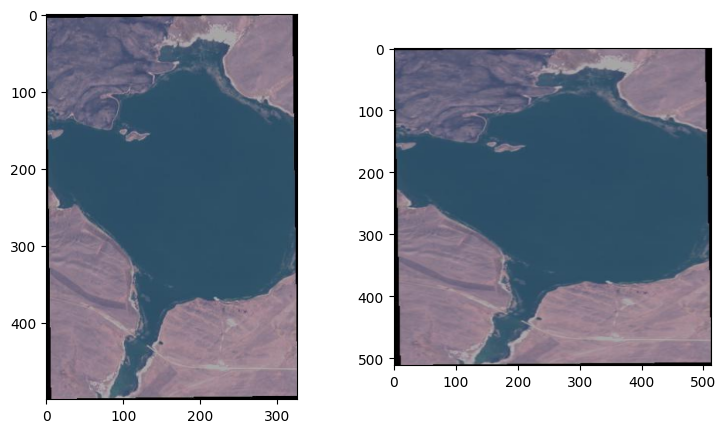

In [ ]:
resizer = v2.Resize((512, 512))
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[6]))
plt.subplot(1,2,2)
plt.imshow(resizer(Image.open(real_data[6])))

### Cropping the image to a size less that size of original image

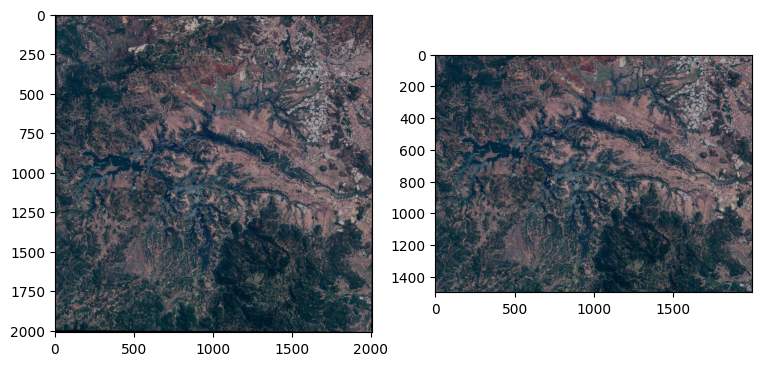

In [ ]:
crop = v2.RandomCrop((1500,2000))
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(crop(Image.open(real_data[0])))

### Test Horizontal Shift

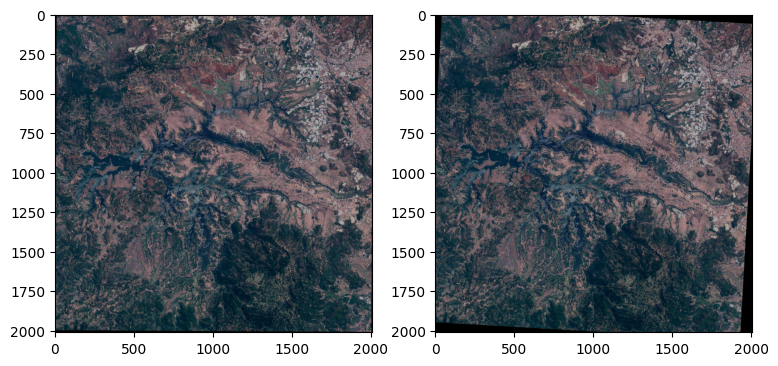

In [ ]:
aff = v2.RandomAffine(degrees=5,translate=(0.05,0),fill=0)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(aff(Image.open(real_data[0])))

### Testing the Random Horizontal Flip on the same image

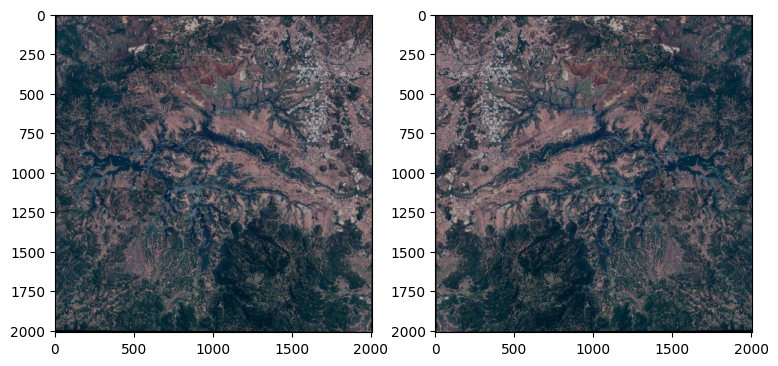

In [ ]:
# Flip takes the probaility as param., so for every run, image may or may not get flipped
hor_flipper = v2.RandomHorizontalFlip(p=0.5)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(hor_flipper(Image.open(real_data[0])))

### Test Random Rotation

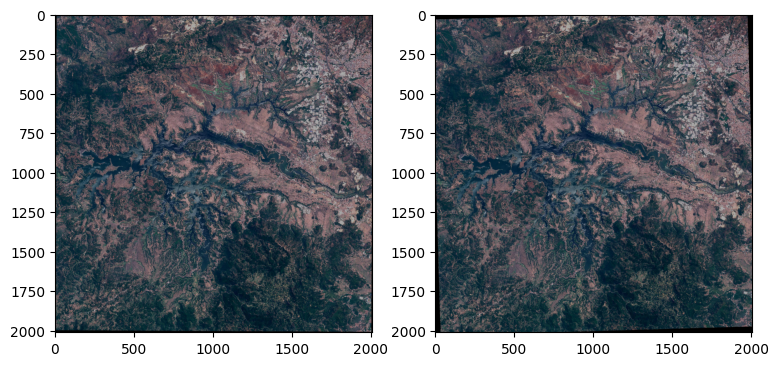

In [ ]:
rot = v2.RandomRotation((0,15),fill=0)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(rot(Image.open(real_data[0])))

### Test Vertical Flip

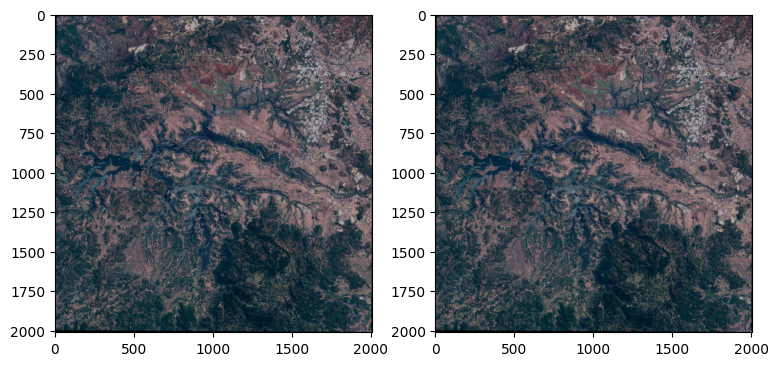

In [ ]:
ver_flipper = v2.RandomVerticalFlip(p=0.1)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(ver_flipper(Image.open(real_data[0])))

### Check color changes

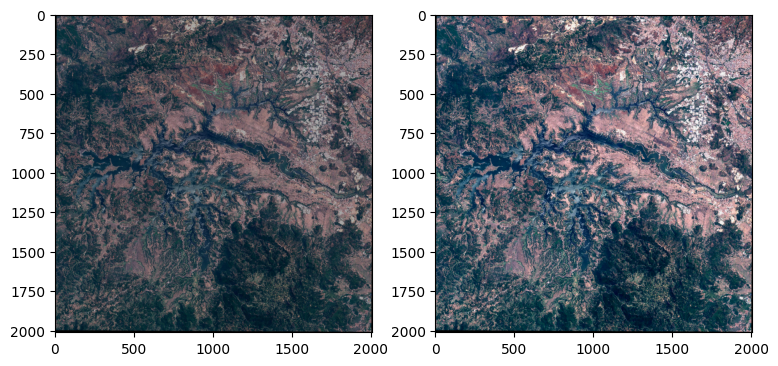

In [ ]:
col_changer = v2.ColorJitter(brightness = 0.35, contrast = 0.35)
# contrast determines the no. of shades. saturation det. the intensity, hue should be less than 0.5
# hue shifts the color values
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(col_changer(Image.open(real_data[0])))

### Check greyscale transformation

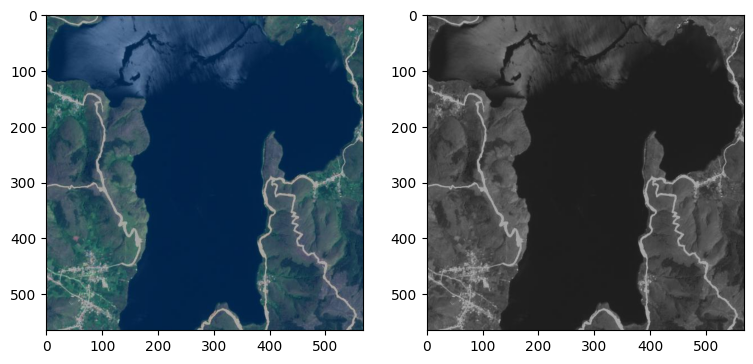

In [ ]:
gray = v2.Grayscale(3)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[2]))
plt.subplot(1,2,2)
plt.imshow(gray(Image.open(real_data[2])))

In [ ]:
print (asarray(Image.open(real_data[2])).shape)
print (asarray(gray(Image.open(real_data[2]))).shape)

(565, 568, 3)
(565, 568, 3)


### **Building the Model: U-Net on PyTorch**

### Dataset Preparation

In [6]:
class SatelliteData(Dataset):
  def __init__(self, real_data, masked_data, transform = None, mask_transform = None):
    super().__init__()

    self.real_data = real_data
    self.masked_data = masked_data

    self.transform = transform
    self.mask_transform = mask_transform

  def __len__(self):
    return len(self.real_data)

  # We locate the file, convert to tensor using read_image, call the transforms (if appl.) and return
  def __getitem__(self, index):
    image = read_image(self.real_data[index])
    if self.transform is not None:
      image = self.transform(image)
      image = image/255.0

    mask = read_image(self.masked_data[index])
    if self.mask_transform is not None:
      mask = self.mask_transform(mask)
      mask = mask/255.0

    return image, mask

In [7]:
# mention int to size if the height = width
transform = v2.Compose([v2.Resize(size = (SIZE,SIZE)),v2.RandomHorizontalFlip(0.1),v2.RandomRotation((0,15)),
                        v2.RandomAffine(degrees=5,translate=(0.05,0)),
                        v2.ColorJitter(brightness = 0.35, contrast = 0.35),
                        v2.RandomVerticalFlip(0.1)])

test_transform = v2.Compose([v2.Resize(size = (SIZE,SIZE))])

mask_transform = v2.Compose([v2.Resize(size = (SIZE,SIZE)),v2.RandomHorizontalFlip(0.1),v2.RandomRotation((0,15),fill=255),
                        v2.RandomAffine(degrees=5,translate=(0.05,0),fill=255),
                        v2.RandomVerticalFlip(0.1),v2.Grayscale(1)])

Testing whether the dataset works or not

In [10]:
obj = SatelliteData(real_data, masked_data)
print (f'Printing some of the values \n {obj.real_data[0:2]} \n {obj.masked_data[0:2]}')
print (f'Printing transformations values: {obj.transform}, {obj.mask_transform}')

Printing some of the values 
 ['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Images/water_body_1.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Images/water_body_10.jpg'] 
 ['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_10.jpg']
Printing transformations values: None, None


In [ ]:
# test the len func
len(obj)

500

In [ ]:
# test the getitem func
print (obj[0][0].shape, obj[0][1].shape)
obj[0][0].dtype

torch.Size([3, 2009, 2007]) torch.Size([3, 2009, 2007])


torch.uint8

In [8]:
# test the transformation
obj = SatelliteData(real_data, masked_data, transform, mask_transform)
print (obj.masked_data[0:2], obj.masked_data[0:2])
print (obj.transform, obj.mask_transform)

obj[0][0].shape, obj[0][1].shape

['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_10.jpg'] ['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_10.jpg']
Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomHorizontalFlip(p=0.1)
      RandomRotation(degrees=[0.0, 15.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      RandomAffine(degrees=[-5.0, 5.0], translate=(0.05, 0), interpolation=InterpolationMode.NEAREST, fill=0)
      ColorJitter(brightness=(0.65, 1.35), contrast=(0.65, 1.35))
      RandomVerticalFlip(p=0.1)
) Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=Tru

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

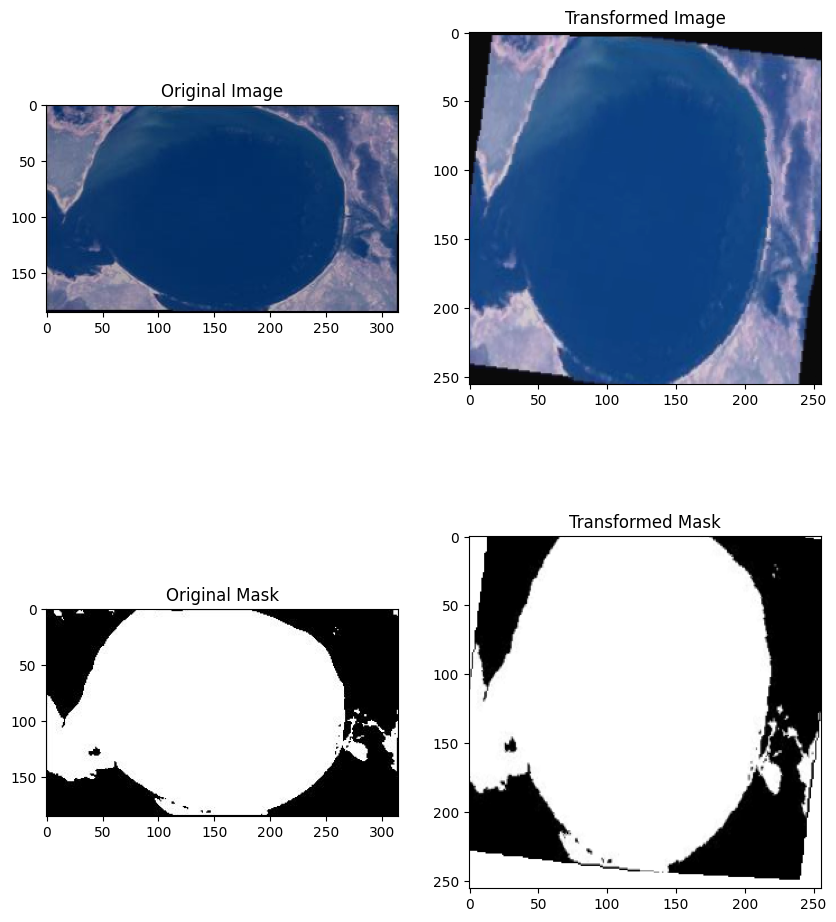

In [9]:
# matplotlib doesn't understand normalization of RGB images, so either convert them to int, or normalize again
plt.figure(figsize=(10,12))
plt.subplot(2,2,1)
plt.title('Original Image')
plt.imshow(read_image(real_data[12]).permute(2,1,0))
plt.subplot(2,2,2)
plt.title('Transformed Image')
plt.imshow(obj[12][0].permute(2,1,0))
plt.subplot(2,2,3)
plt.title('Original Mask')
plt.imshow(read_image(masked_data[12]).permute(2,1,0))
plt.subplot(2,2,4)
plt.title('Transformed Mask')
plt.imshow(obj[12][1].permute(2,1,0),cmap = 'gray')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(real_data, masked_data, test_size=0.1, random_state=SEED)

In [11]:
train_data = SatelliteData(X_train, y_train, transform, mask_transform)
test_data = SatelliteData(X_test, y_test,test_transform,mask_transform)

In [12]:
# num_workers represents the no. of batches that will be parallelly loaded: Windows needs to have a main() imple.- Not exce. now
train_loader = DataLoader(train_data,batch_size=BATCH,shuffle=True)
test_loader = DataLoader(test_data,batch_size=BATCH, shuffle = False)

In [40]:
print (len(train_data), len(train_loader))
print (len(test_data), len(test_loader))

450 15
50 2


torch.Size([32, 3, 256, 256]) torch.Size([3, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([1, 256, 256])


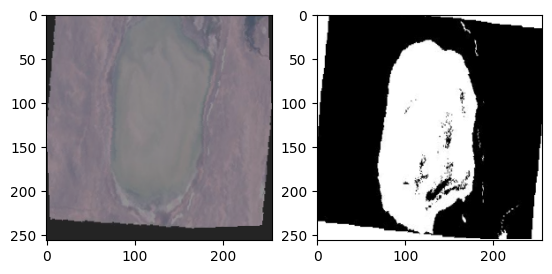

In [13]:
# test the train data loader
for i, (x,y) in enumerate(train_loader):
  print (x.shape, x[0].shape)
  print (y.shape, y[0].shape)
  plt.subplot(1,2,1)
  plt.imshow(x[1].permute(2,1,0))
  plt.subplot(1,2,2)
  # pyplot uses a default colormap showing in yellow/purple, use cmap = gray for B/W
  plt.imshow(y[1].permute(2,1,0),cmap = 'gray')
  break

torch.Size([32, 3, 256, 256]) torch.Size([3, 256, 256])


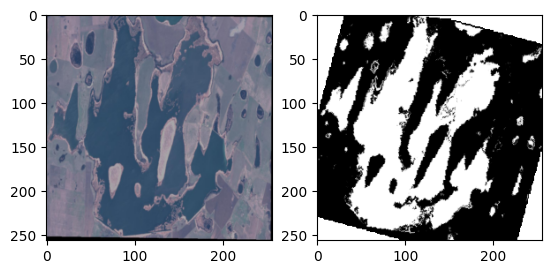

In [14]:
# test the val data loader
for i, (x,y) in enumerate(test_loader):
  print (x.shape, x[0].shape)
  plt.subplot(1,2,1)
  plt.imshow(x[1].permute(2,1,0))
  plt.subplot(1,2,2)
  plt.imshow(y[1].permute(2,1,0),cmap = 'gray')
  break

### Defining the model for binary segmentation

Understanding UNet: Every pixel is broken into water or non-water class

In [15]:
class DoubleConv(nn.Module):

  def __init__(self,num_in_chan, num_out_chan):
    super().__init__()

    # same padding ensures that the size of o/p feature map is the same as i/p
    # batch_norm has its own bias paramater called the shift_param (alpha and beta)
    # The shift_params overwrite the Conv2D's bias, hence we remove the redundant bias
    self.conv_block = nn.Sequential(
    nn.Conv2d(num_in_chan,num_out_chan,padding='same',kernel_size=(3,3)),
    nn.BatchNorm2d(num_out_chan),
    nn.ReLU(inplace = True),

    nn.Conv2d(num_out_chan,num_out_chan,padding='same',kernel_size=(3,3)),
    nn.BatchNorm2d(num_out_chan),
    nn.ReLU(inplace = True))

  def forward(self,x):
      return self.conv_block(x)

In [16]:
# Create the Downsampling Block
class encoder(nn.Module):
  def __init__(self,num_in_chan,num_out_chan):
    super().__init__()
    self.conv_block = DoubleConv(num_in_chan,num_out_chan)
    self.pool = nn.MaxPool2d(2)

  def forward(self,x):
    side = self.conv_block(x)
    down = self.pool(side)
    return side,down

In [17]:
# Create the Upsampling Block
class decoder(nn.Module):
  def __init__(self,num_in_chan,num_out_chan):
    super().__init__()
    # stride = 2 in order to maintain the channel size to its corresponding conv2d layer
    # for ConvTranspose2d, padding should be an int/tuple and not string
    self.conv1 = nn.ConvTranspose2d(num_in_chan,num_out_chan,kernel_size=2,stride=2,padding=0)
    # no. of channels is twice to align with the channel dim. input = down + its corresponding conv2d side
    self.conv2 = DoubleConv(num_out_chan*2,num_out_chan)

  def forward(self,x,side):
    x = self.conv1(x)
    # The channels from side and down are concatenated. Shape is (Batch, Channel, Height, Width) hence dim=1
    x = torch.cat([x,side],dim=1)
    x = self.conv2(x)
    return x

In [18]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder1 = encoder(3,64)
    self.encoder2 = encoder(64,128)
    self.encoder3 = encoder(128,256)
    self.encoder4 = encoder(256,512)

    self.b1 = DoubleConv(512,1024)

    self.decoder1 = decoder(1024,512)
    self.decoder2 = decoder(512,256)
    self.decoder3 = decoder(256,128)
    self.decoder4 = decoder(128,64)

    # channels = 1 as this is a binary segmentation- water as the foreground vs. rem. as the background
    # for n classes, use channels = n
    self.output = nn.Conv2d(64,1,kernel_size=(1,1))

  def forward(self,x):
    side1,down1 = self.encoder1(x)
    side2,down2 = self.encoder2(down1)
    side3,down3 = self.encoder3(down2)
    side4,down4 = self.encoder4(down3)

    # we don't call sigmoid here as we use the loss function BCEWithLogitsLoss()
    b1_out = self.b1(down4)

    d1 = self.decoder1(b1_out,side4)
    d2 = self.decoder2(d1,side3)
    d3 = self.decoder3(d2,side2)
    d4 = self.decoder4(d3,side1)

    return self.output(d4)

Test the Model's output shape

In [19]:
x = torch.randn((3,3,128,128))
x.shape

torch.Size([3, 3, 128, 128])

In [ ]:
samp = UNet()
print (samp(x).shape, samp(x)[0][0])

### Model Training and Evaluation

In [25]:
def train_model(train_loader,model,optimizer,criterion):
  epoch_loss = 0.0
  model.train()
  loop = tqdm(train_loader)
  for i, (X,y) in enumerate(loop):
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred,y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    loop.set_postfix(loss = loss.item())
  return epoch_loss/len(train_loader)

In [ ]:
# Testing the train model function
criterion = nn.BCEWithLogitsLoss()
model = UNet()
optimizer = torch.optim.Adam(model.parameters())
model.train()
loop = tqdm(train_loader)
for i, (X,y) in enumerate(loop):
  X = X.to(device, dtype = torch.float32)
  y = y.to(device,type = torch.float32)
  y_pred = model(X)
  print (f'\n Prediction: max is {torch.max(y_pred)}, min is {torch.min(y_pred)}')
  print (f'\n Actual: max is {torch.max(y)}, min is {torch.min(y)}')
  optimizer.zero_grad()
  loss = criterion(y_pred,y)
  loss.backward()
  optimizer.step()
  loop.set_postfix(loss = loss.item())
  if (i==1):
    break

***Loss was becoming negative for the first run***

**Reason**: BCEWithLogitsLoss(predictions, actuals) needs predictions and actuals to belong in the range (-inf, inf) and actuals in (0,1).  In my case, input y was not normalized, hence dividing value by 255.0 becomes important

In [29]:
def eval_model(test_loader,model):
  epoch_loss = 0.0
  model.eval()
  with torch.no_grad():
    loop = tqdm(test_loader)
    for i,(X,y) in enumerate(loop):
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss = criterion(y_pred,y)
      epoch_loss += loss.item()
  return epoch_loss/len(test_loader)

In [18]:
# testing the eval_model function
model = UNet()
model.eval()
with torch.no_grad():
  loop = tqdm(test_loader)
  for i,(X,y) in enumerate(loop):
    X = X.to(device)
    y = y.to(device)
    y_pred = torch.sigmoid(model(X))
    print (y_pred.shape)
    break
    print (torch.sigmoid(y_pred), torch.sigmoid(y_pred).shape)
    num_correct = num_correct + (y == y_pred).sum()
    num_pixels = num_pixels + torch.numel(y_pred)
    print (num_correct, num_pixels)
    loss = criterion(y_pred,y)
    loop.set_postfix(loss = loss.item(), accuracy = (num_correct/num_pixels)*100)
    break

  0%|          | 0/2 [02:05<?, ?it/s]

torch.Size([32, 1, 256, 256])


### ToDo: About Dice Loss:

Dice coeff. = 2*Overlap between Pred versus actual/Area of Pred + Actual
Dice Loss = 1 - Dice Coeff.

Here, for every iteration, 2*overlap further decreases the loss compared to IoU, making it a better metric for obj. segmentation

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)
model = UNet()
model = model.to(device)

cpu


In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [30]:
# objective of loss function is not to minimize loss, but to bring it to 0
train, val, best_val_loss = [],[], float('inf')
for epoch in range(EPOCHS):
  train_loss = train_model(train_loader,model,optimizer,criterion)
  train.append(train_loss)
  val_loss = eval_model(test_loader,model)
  val.append(val_loss)

  if best_val_loss > val_loss:
    print (f'Best Validation loss is reduced from {best_val_loss} to {val_loss}')
    best_val_loss = val_loss
    torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/BestModel.pt')

  print (f'For epoch no.{epoch}')
  print (f'Train loss:{train_loss}, Validation loss:{val_loss}')

100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


Best Validation loss is reduced from inf to 0.6425635516643524
For epoch no.0
Train loss:0.5744711677233378, Validation loss:0.6425635516643524


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Best Validation loss is reduced from 0.6425635516643524 to 0.5786916017532349
For epoch no.1
Train loss:0.5750006079673767, Validation loss:0.5786916017532349


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Best Validation loss is reduced from 0.5786916017532349 to 0.5490660071372986
For epoch no.2
Train loss:0.5812765598297119, Validation loss:0.5490660071372986


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


For epoch no.3
Train loss:0.5711947957674662, Validation loss:0.5608596503734589


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


For epoch no.4
Train loss:0.559472938378652, Validation loss:0.550761878490448


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


For epoch no.5
Train loss:0.5843684057394664, Validation loss:0.5562973618507385


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


For epoch no.6
Train loss:0.5946157733599345, Validation loss:0.5889497399330139


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


For epoch no.7
Train loss:0.5788909832636515, Validation loss:0.5626267343759537


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


For epoch no.8
Train loss:0.5621202369530995, Validation loss:0.5860584378242493


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Best Validation loss is reduced from 0.5490660071372986 to 0.5363712459802628
For epoch no.9
Train loss:0.5647265632947286, Validation loss:0.5363712459802628


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


For epoch no.10
Train loss:0.5711086432139079, Validation loss:0.5728242099285126


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


For epoch no.11
Train loss:0.5593482355276743, Validation loss:0.5430159121751785


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


For epoch no.12
Train loss:0.5703830361366272, Validation loss:0.5598491132259369


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


For epoch no.13
Train loss:0.559653083483378, Validation loss:0.7419275939464569


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Best Validation loss is reduced from 0.5363712459802628 to 0.5308048576116562
For epoch no.14
Train loss:0.5571182986100515, Validation loss:0.5308048576116562


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


For epoch no.15
Train loss:0.5640474538008372, Validation loss:0.5457955598831177


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


For epoch no.16
Train loss:0.5509944438934327, Validation loss:0.5440634489059448


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


For epoch no.17
Train loss:0.5735726356506348, Validation loss:0.5699872076511383


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


For epoch no.18
Train loss:0.5610364596048991, Validation loss:0.5428057909011841


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


For epoch no.19
Train loss:0.567718094587326, Validation loss:0.5537625849246979


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Best Validation loss is reduced from 0.5308048576116562 to 0.5149841755628586
For epoch no.20
Train loss:0.5673233509063721, Validation loss:0.5149841755628586


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


For epoch no.21
Train loss:0.5512791991233825, Validation loss:0.5329618453979492


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


For epoch no.22
Train loss:0.5626749674479167, Validation loss:0.5276295244693756


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


For epoch no.23
Train loss:0.5824219703674316, Validation loss:0.5837387442588806


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


For epoch no.24
Train loss:0.5793158014615377, Validation loss:0.5697004497051239


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


For epoch no.25
Train loss:0.5575359503428141, Validation loss:0.5753442645072937


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


For epoch no.26
Train loss:0.5501374920209249, Validation loss:0.519951194524765


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


For epoch no.27
Train loss:0.5374000787734985, Validation loss:0.5240268707275391


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


For epoch no.28
Train loss:0.5595977564652761, Validation loss:0.5577825903892517


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


For epoch no.29
Train loss:0.5468637228012085, Validation loss:0.5195651799440384


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


For epoch no.30
Train loss:0.5369470000267029, Validation loss:0.5431188344955444


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


For epoch no.31
Train loss:0.5452609260876974, Validation loss:0.5299023389816284


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


For epoch no.32
Train loss:0.5403548777103424, Validation loss:0.5290280729532242


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


For epoch no.33
Train loss:0.5434079031149547, Validation loss:0.5380307734012604


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Best Validation loss is reduced from 0.5149841755628586 to 0.493992418050766
For epoch no.34
Train loss:0.5246820072333018, Validation loss:0.493992418050766


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


For epoch no.35
Train loss:0.5337690273920696, Validation loss:0.6572169363498688


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


For epoch no.36
Train loss:0.5317737241586049, Validation loss:0.49931465089321136


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


For epoch no.37
Train loss:0.5314766089121501, Validation loss:0.510157972574234


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


For epoch no.38
Train loss:0.5186055759588878, Validation loss:0.5012622177600861


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


For epoch no.39
Train loss:0.5092407802740733, Validation loss:0.5203650742769241


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Best Validation loss is reduced from 0.493992418050766 to 0.4746098965406418
For epoch no.40
Train loss:0.5161828835805257, Validation loss:0.4746098965406418


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


For epoch no.41
Train loss:0.5100951393445333, Validation loss:0.47682642936706543


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


For epoch no.42
Train loss:0.5072487552960714, Validation loss:0.5061175227165222


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


For epoch no.43
Train loss:0.5220579981803894, Validation loss:0.5142435282468796


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


For epoch no.44
Train loss:0.5141010403633117, Validation loss:0.4920455515384674


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


For epoch no.45
Train loss:0.521492201089859, Validation loss:0.4848718196153641


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


For epoch no.46
Train loss:0.5058416465918223, Validation loss:0.5171375572681427


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


For epoch no.47
Train loss:0.49848345915476483, Validation loss:0.49513471126556396


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


For epoch no.48
Train loss:0.5056341449419658, Validation loss:0.485729455947876


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

For epoch no.49
Train loss:0.5114055017630259, Validation loss:0.49214015901088715


In [25]:
# best_model_state = torch.load('/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/BestModel.pt')
best_model_state = torch.load('/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/BestModel.pt',
                             map_location=torch.device('cpu'))

In [26]:
best_model = UNet()
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

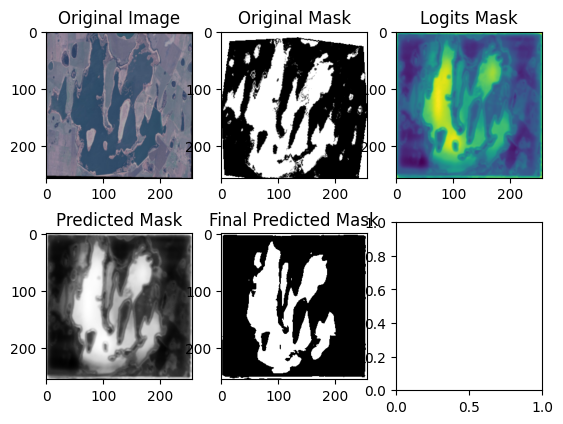

In [30]:
i, m = test_data[1]
f,ax = plt.subplots(2,3)
ax[0][0].imshow(i.permute(2,1,0))
ax[0][1].imshow(m.permute(2,1,0),cmap = 'gray')
ax[0][2].imshow(np.transpose(torch.squeeze(best_model(i.unsqueeze(0)),0).detach().numpy()))
ax[1][0].imshow(np.transpose(torch.squeeze(torch.sigmoid(best_model(i.unsqueeze(0))),0).detach().numpy()),cmap = 'gray')
ax[1][1].imshow(np.transpose(torch.squeeze(torch.round(torch.sigmoid(best_model(i.unsqueeze(0)))),0).detach().numpy()),cmap = 'gray')
ax[0][0].title.set_text('Original Image')
ax[0][1].title.set_text('Original Mask')
ax[0][2].title.set_text('Logits Mask')
ax[1][0].title.set_text('Predicted Mask')
ax[1][1].title.set_text('Final Predicted Mask')

In [56]:
i, m = test_data[1]
p = torch.squeeze(torch.round(torch.sigmoid(best_model(i.unsqueeze(0)))),0)

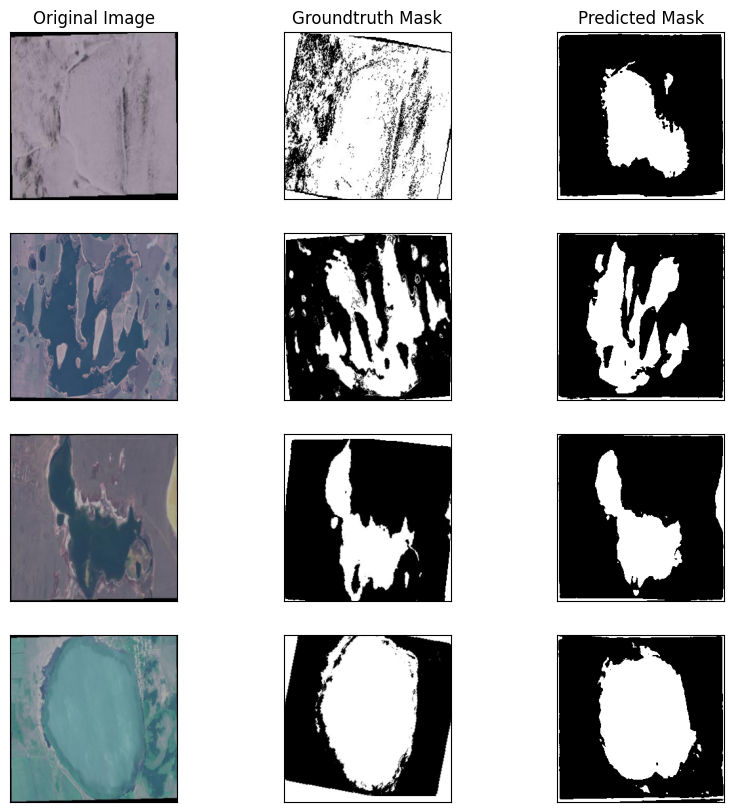

In [36]:
f,ax = plt.subplots(4,3,figsize=(10,10))

ax[0][0].imshow(test_data[0][0].permute(2,1,0))
ax[0][1].imshow(test_data[0][1].permute(2,1,0),cmap='gray')
ax[0][2].imshow(np.transpose(torch.squeeze(torch.round(torch.sigmoid(best_model(test_data[0][0].unsqueeze(0)))),0).detach().numpy()),cmap = 'gray')

ax[1][0].imshow(test_data[1][0].permute(2,1,0))
ax[1][1].imshow(test_data[1][1].permute(2,1,0),cmap='gray')
ax[1][2].imshow(np.transpose(torch.squeeze(torch.round(torch.sigmoid(best_model(test_data[1][0].unsqueeze(0)))),0).detach().numpy()),cmap = 'gray')

ax[2][0].imshow(test_data[2][0].permute(2,1,0))
ax[2][1].imshow(test_data[2][1].permute(2,1,0),cmap='gray')
ax[2][2].imshow(np.transpose(torch.squeeze(torch.round(torch.sigmoid(best_model(test_data[2][0].unsqueeze(0)))),0).detach().numpy()),cmap = 'gray')

ax[3][0].imshow(test_data[3][0].permute(2,1,0))
ax[3][1].imshow(test_data[3][1].permute(2,1,0),cmap='gray')
ax[3][2].imshow(np.transpose(torch.squeeze(torch.round(torch.sigmoid(best_model(test_data[3][0].unsqueeze(0)))),0).detach().numpy()),cmap = 'gray')

for i in range(4):
  for j in range(3):
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

ax[0][0].title.set_text('Original Image')
ax[0][1].title.set_text('Groundtruth Mask')
ax[0][2].title.set_text('Predicted Mask')